In [1]:
# import data manipulation libraries
import pandas as pd
import numpy as np
 
# import data viz libraries 
import matplotlib.pyplot as plt
import seaborn as sns



Read in Data

In [5]:
train = pd.read_csv("train_ticket_data.csv",
                    parse_dates=["departure"],
                    dtype={
                        "origin": "category",
                        "destination": "category",
                        "vehicle_type": "category",
                        "vehicle_class": "category",
                        "fare":"category"
                    }
                   ).drop("Unnamed: 0", axis=1)

#Create new columns and check for missing data

In [6]:
from pandas.api.types import CategoricalDtype
 
# created ordered category for weekday. integer dayofweek is ok, but less helpful for customers
 
cat_type = CategoricalDtype(
    categories=[
        "Monday", 
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday"
    ], 
    ordered=True)
 
# Create departure, day_of_week, and hour columns
 
train = train.assign(
    arrival= train["departure"] + pd.to_timedelta(train["duration"], unit="H"),
    departure_dayofweek = (train["departure"].dt.day_name().astype(cat_type)),
    departure_hour = train["departure"].dt.hour,
    vehicle_category = (train["vehicle_type"]
                        .map({"AVE": "High-Speed", 
                              "AVE-TGV": "High-Speed", 
                              "R. EXPRES": "Standard",
                              "LD-AVE": "Standard",
                              "AVE-LD": "Standard",
                              "MD-AVE": "Standard",
                              "LD-MD": "Standard"                          
                        }))
)

Generate key summary statistics for Management

In [7]:
train.describe().round()

,duration,price,departure_hour
count,1525950.0,1458886.0,1525950.0
mean,3.0,86.0,13.0
std,1.0,22.0,5.0
min,2.0,41.0,5.0
25%,2.0,75.0,8.0
50%,3.0,85.0,13.0
75%,3.0,100.0,17.0
max,11.0,235.0,21.0


In [ ]:
train.loc[train["price"] == train["price"].max()]

In [8]:
train.loc[train["price"] == train["price"].min()]

,origin,destination,departure,duration,vehicle_type,vehicle_class,price,fare,arrival,departure_dayofweek,departure_hour,vehicle_category
1416363,BARCELONA,MADRID,2019-05-28 21:15:00,2.78,AVE,Turista,40.93,Promo,2019-05-29 00:01:48,Tuesday,21,High-Speed
1416383,BARCELONA,MADRID,2019-05-28 21:15:00,2.78,AVE,Turista,40.93,Promo,2019-05-29 00:01:48,Tuesday,21,High-Speed
1419884,BARCELONA,MADRID,2019-05-28 21:15:00,2.78,AVE,Turista,40.93,Promo,2019-05-29 00:01:48,Tuesday,21,High-Speed
1419913,BARCELONA,MADRID,2019-05-28 21:15:00,2.78,AVE,Turista,40.93,Promo,2019-05-29 00:01:48,Tuesday,21,High-Speed


In [9]:
train.query("origin == 'MADRID'").price.mean()

86.01552504730397

In [10]:
train.query("origin == 'BARCELONA'").price.mean()

86.33105082341281

Build charts for management report

In [11]:
train_summary = (train
 .groupby(train["departure"].dt.date)
 .agg(
     ridership = ("price", "count"),
     total_fare = ("price", "sum"),
      )
).reset_index()

In [12]:
train_summary.head()

,departure,ridership,total_fare
0,2019-05-01,27752,2245333.78
1,2019-05-02,28602,2119504.40
2,2019-05-03,32322,2921006.38
3,2019-05-04,22838,1948140.10
4,2019-05-05,31110,3215268.30


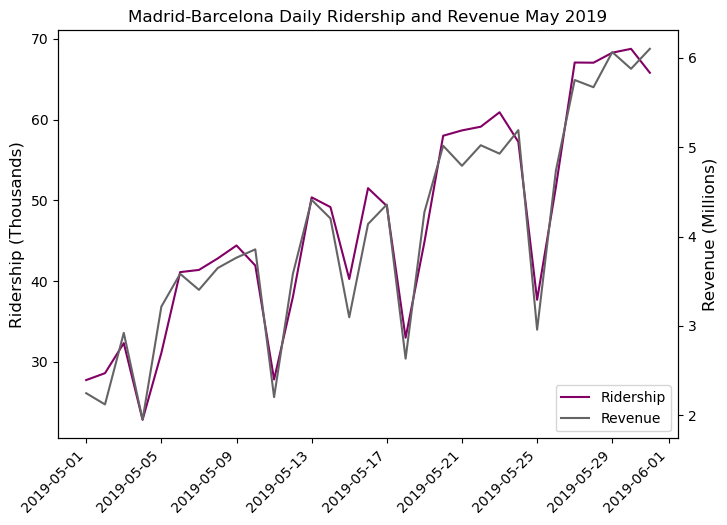

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
 
ax.set_title("Madrid-Barcelona Daily Ridership and Revenue May 2019")
 
ax.plot(
    train_summary["departure"], 
    train_summary["ridership"] / 1000, # divide by thousands to change units
    c="#830065",
    label="Ridership"
)
ax.set_ylabel("Ridership (Thousands)", fontsize=12)
 
ax2 = ax.twinx()
 
ax2.plot(
    train_summary["departure"], 
    train_summary["total_fare"] / 1000000, # divide by millions to change units
    c="#666366",
    label="Revenue"
)
ax2.set_ylabel("Revenue (Millions)", fontsize=12)
 
fig.autofmt_xdate(rotation=45)
fig.legend(bbox_to_anchor=(.9, .3))
 
plt.show()

BUILD DAILY RIDERSHIP CHART

In [ ]:
df = (train
      .groupby(["departure_dayofweek", "origin"])
      .agg(ridership = ("price", "count"))
     ).reset_index()
df.head() 

In [ ]:
sns.barplot(x="departure_dayofweek", y="ridership", hue="origin", data=df)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
 
sns.barplot(
    data=df,
    x="departure_dayofweek",
    y="ridership",
    hue="origin",
    palette=["#830065", "#666366"]   
).set(
    title='Ridership by Weekday and Departure Location',
    xlabel="Departure Day",
    ylabel="Ridership Volume"
)
 
sns.despine()

produce information and visuals for customer help site

In [ ]:
train_summary = (
    train
    .groupby("vehicle_category")
    .agg(
        average_fare = ("price", "mean"),
        average_duration = ("duration", "mean")
    )
)
 
train_summary.head()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
 
fig.suptitle("Standard Trains are Cheaper, but Take Much Longer")
 
ax[0].bar(
    x=train_summary.index, 
    height=train_summary["average_fare"],
    color="#830065",
)
 
ax[0].set_title("Price by Train Type")
ax[0].set_ylabel("Price (Euro)")
 
ax[1].bar(
    x=train_summary.index, 
    height=train_summary["average_duration"],
    color="#666366",
)
 
ax[1].set_title("Trip Duration by Train Type")
ax[1].set_ylabel("Duration (Hours)")
 
plt.show()

HEATMAP AND EXPORT SUMMARY TABLE

In [ ]:
heatmap = train.pivot_table(
    index="departure_hour",
    columns="departure_dayofweek",
    values="price",
    aggfunc="mean"
)
 
heatmap

In [ ]:
heatmap.style.background_gradient("RdYlGn_r", axis=None)

EXPORTING DATAFRAME USED TO BUILD THE HEATMAP TO CSV FILE

In [ ]:
heatmap.to_csv("price_heatmap.csv")